In [1]:
import requests
import bs4 as bs
from bs4 import BeautifulSoup
import selenium
from selenium import webdriver
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from matplotlib.patches import Arc, Rectangle, ConnectionPatch
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from pandas.io.json import json_normalize
from sklearn.metrics.pairwise import cosine_similarity
import re
import json
import ast
import time

ModuleNotFoundError: No module named 'requests'

In [2]:
def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    def draw_poly_patch(self):
        # rotate theta such that the first axis is at the top
        verts = unit_poly_verts(theta + np.pi / 2)
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 10)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 2
        # define draw_frame method
        draw_patch = patch_dict[frame]

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels, **kwargs):
            
            self.set_thetagrids(np.degrees(theta), labels, **kwargs)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.

            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta + np.pi / 2)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)

            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta


def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.

    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts

In [3]:
'''
instantiate chrome web drive and specify the direction where 
the files will be downloaded in download default directory parameter. 

league_dict is a dictionary that contains each league that 
we want to scrap as key and its id in fbref as the value. 
This helps us to scrap the url of each league.

titles is a list of the title of the tables that we are
scraping for each team. This helps us in naming the directories
when the data is being scraped
'''


chrome_options = webdriver.ChromeOptions()
profile = {"download.default_directory": "C:\\Users\\Yassine\\defenders_data",
           "download.prompt_for_download": False,
           "download.directory_upgrade": True,
          }
chrome_options.add_experimental_option("prefs", profile)

url  = "https://www.fbref.com/"

leagues_dict = {'Serie_A': '11', 'SuperLiga': '32', 'MLS': '22', 'Eridivisie': '23', 'Ligue_1': '13', 'Premier_League': '9', 'La_Liga': '12'
                ,'Bundesliga':'20'}

titles = ["standard_stats", "shooting", "passing", "pass_types", "goal_shot_creation", "defensive_action", "possesion", 
          "playing_time", "misc_stats", "player_summary", "gk_summary"] 

file_name = "sportsref_download.csv"
defender_template_files = ["passing", "defensive_action", "misc_stats"] 

NameError: name 'webdriver' is not defined

In [4]:

'''
get all the teams and their respective links in FBref by scraping javascript from the website
it returns a dictionary containg each league id in keys and a list of dictionaries (link in key, team name in value) 
of the league teams in values
'''

def get_leagues_teams():
    
    driver=webdriver.Chrome(options=chrome_options, executable_path=r'C:\Users\Yassine\Downloads\chromedriver_win32\chromedriver.exe')
    driver.get(url)
    soup = BeautifulSoup(driver.page_source,"html.parser")
    scripts = soup.find_all('script')
    for script in scripts:
        if "sr_goto_json" in script.get_text():
            teams_urls = script.get_text()
            break
    t = teams_urls.replace("\n","").split("=")[5:][0][:-1].replace(", }", "}")
    leagues = eval(t.replace(" ",""))
    leagues_keys = list(leagues.keys())
    leagues_teams = list(leagues.values())
    for league in leagues_keys:
        teams = leagues[league][1:]
        leagues[league] = teams
    driver.close()
    return leagues

In [5]:
leagues = get_leagues_teams()

NameError: name 'webdriver' is not defined

In [6]:
leagues

{'11': [{'/en/squads/922493f3/Atalanta-Stats': 'Atalanta'},
  {'/en/squads/1d8099f8/Bologna-Stats': 'Bologna'},
  {'/en/squads/4ef57aeb/Brescia-Stats': 'Brescia'},
  {'/en/squads/c4260e09/Cagliari-Stats': 'Cagliari'},
  {'/en/squads/421387cf/Fiorentina-Stats': 'Fiorentina'},
  {'/en/squads/658bf2de/Genoa-Stats': 'Genoa'},
  {'/en/squads/0e72edf2/Hellas-Verona-Stats': 'HellasVerona'},
  {'/en/squads/d609edc0/Internazionale-Stats': 'Internazionale'},
  {'/en/squads/e0652b02/Juventus-Stats': 'Juventus'},
  {'/en/squads/7213da33/Lazio-Stats': 'Lazio'},
  {'/en/squads/ffcbe334/Lecce-Stats': 'Lecce'},
  {'/en/squads/dc56fe14/Milan-Stats': 'Milan'},
  {'/en/squads/d48ad4ff/Napoli-Stats': 'Napoli'},
  {'/en/squads/eab4234c/Parma-Stats': 'Parma'},
  {'/en/squads/cf74a709/Roma-Stats': 'Roma'},
  {'/en/squads/8ff9e3b3/Sampdoria-Stats': 'Sampdoria'},
  {'/en/squads/e2befd26/Sassuolo-Stats': 'Sassuolo'},
  {'/en/squads/1d2fe027/SPAL-Stats': 'SPAL'},
  {'/en/squads/105360fe/Torino-Stats': 'Torino'},

In [7]:

'''
this function gets the statistics tables mentioned in titles. The league name is passed as an argument . 
The statistics are got for each team in that specific league.
'''
def get_league_stats(league_name):
    
    leagues = get_leagues_teams() 
    if league_name in list(leagues_dict.keys()):
            for team in leagues[leagues_dict[league_name]]:
                    indices = []
                    profile = {"download.default_directory": "C:\\Users\\Yassine\\defenders_data",
                                "download.prompt_for_download": False,
                                "download.directory_upgrade": True,
                                  }
                    chrome_options.add_experimental_option("prefs", profile)
                    driver=webdriver.Chrome(options=chrome_options, executable_path=r'C:\Users\Yassine\Downloads\chromedriver_win32\chromedriver.exe')
                    driver.get(url + list(team.keys())[0])
                    elements = driver.find_elements_by_tag_name('button')
                    for element in elements: 
                        if "comma" in str(element.get_attribute("tip")):
                            indices.append(elements.index(element))
                    driver.close()
                    del indices[1:4]
                    print(len(indices))
                    for x in range(0,len(titles)):                            
                        try:
                            profile = {"download.default_directory": "C:\\Users\\Yassine\\defenders_data\\" + str(league_name) + "\\" + str(list(team.values())[0]) + "\\" + titles[x],
                               "download.prompt_for_download": False,
                               "download.directory_upgrade": True, }
                            
                            chrome_options.add_experimental_option("prefs", profile)
                            driver=webdriver.Chrome(options=chrome_options, executable_path=r'C:\Users\Yassine\Downloads\chromedriver_win32\chromedriver.exe')
                            driver.get(url + list(team.keys())[0])
                            elements = driver.find_elements_by_tag_name('button')[indices[x]]
                            driver.execute_script("arguments[0].click();", elements)
                            time.sleep(5)
                            driver.close()
                        except:
                            print("Something wrong Happened" + str(list(team.values())[0]))
                    
        


In [8]:
'''
This function takes as an argument a league name and returns a list of the links of all the games that have been played 
in that league
'''
def get_fixtures_links(league_name):  
    link = league_name + " Fixtures"
    fixtures_links = []
    profile = {"download.default_directory": "C:\\Users\\Yassine",
                                "download.prompt_for_download": False,
                                "download.directory_upgrade": True,
                                  }
    chrome_options.add_experimental_option("prefs", profile)
    driver=webdriver.Chrome(options=chrome_options, executable_path=r'C:\Users\Yassine\Downloads\chromedriver_win32\chromedriver.exe')
    driver.get(url+'\\' + 'en' + '\\' + 'comps' + '\\' +leagues_dict[league_name] + '\\' + 'schedule' + '\\'+ link.replace(" ", "-") )
    elements = driver.find_elements_by_tag_name('a')
    for element in elements: 
        if "matches" in str(element.get_attribute("href")) and "Premier" in str(element.get_attribute("href")).split("-") and str(element.get_attribute("href")) not in fixtures_links:
            fixtures_links.append(str(element.get_attribute("href")))
    driver.close()
    return fixtures_links   
    

In [6]:
fixtures_links = get_fixtures_links("Premier League")

In [ ]:
'''
This code is for scrapping the data of all the fixtures in the PL.
'''


sections  = ['summary','passing','passing_types','defense','possession','misc']
for fixture in range(0,len(fixtures_links)):
    profile = {"download.default_directory": "C:\\Users\\Yassine\\",
            "download.prompt_for_download": False,
            "download.directory_upgrade": True,
            "profile.default_content_setting_values.automatic_downloads": 1}
    chrome_options.add_experimental_option("prefs", profile)
    driver=webdriver.Chrome(options=chrome_options, executable_path=r'C:\Users\Yassine\Downloads\chromedriver_win32\chromedriver.exe')
    driver.get(fixtures_links[fixture])
    tabs = driver.find_elements_by_xpath('//div[contains(@id,  "stats")]')
    ids = []
    for tab in tabs:
        if "summary" in tab.get_attribute('id'):
            if tab.get_attribute('id').split("_")[2] not in ids:
                ids.append(tab.get_attribute('id').split("_")[2])
    driver.close()
    try: 
        for i in range(0,17):
            if i in range(0,6):
                profile = {"download.default_directory": "C:\\Users\\Yassine\\fixtures_data\\" + fixtures_links[fixture].split("/")[-1] + "\\" + ids[0] + "\\" + sections[i],
                           "download.prompt_for_download": False,
                           "download.directory_upgrade": True,
                           "profile.default_content_setting_values.automatic_downloads": 1}
                chrome_options.add_experimental_option("prefs", profile)
                driver=webdriver.Chrome(options=chrome_options, executable_path=r'C:\Users\Yassine\Downloads\chromedriver_win32\chromedriver.exe')
                driver.get(fixtures_links[fixture])
                id = "all_stats_" + ids[0] + "_" + sections[i]
                button = "#all_stats_" + ids[0] + "_" + sections[i]
                table_button = driver.find_element_by_xpath("//div[@id = '" + id + "']//button[@data-show = '" + button + "' ]")
                driver.execute_script("arguments[0].click();",table_button)
                time.sleep(2)
                download_button = driver.find_element_by_xpath('//div[@id = "' + id + '"]//div[@class ="section_heading"]//li[@class="hasmore"]//button[contains(@tip, "comma")]')
                driver.execute_script("arguments[0].click();",download_button)
                time.sleep(2)                                                                                       
            if i == 6:
                profile = {"download.default_directory": "C:\\Users\\Yassine\\fixtures_data\\" + fixtures_links[fixture].split("/")[-1] + "\\" + ids[0] + "\\" + "keeper",
                           "download.prompt_for_download": False,
                           "download.directory_upgrade": True,
                           "profile.default_content_setting_values.automatic_downloads": 1}
                chrome_options.add_experimental_option("prefs", profile)
                driver=webdriver.Chrome(options=chrome_options, executable_path=r'C:\Users\Yassine\Downloads\chromedriver_win32\chromedriver.exe')
                driver.get(fixtures_links[fixture])                                                                                                  
                id = "all_keeper_stats_" + ids[0]
                download_button = driver.find_element_by_xpath('//div[@id = "' + id + '"]//div[@class ="section_heading"]//li[@class="hasmore"]//button[contains(@tip, "comma")]')
                driver.execute_script("arguments[0].click();",download_button)
                time.sleep(2)
            if i in range(7,13):
                profile = {"download.default_directory": "C:\\Users\\Yassine\\fixtures_data\\" + fixtures_links[fixture].split("/")[-1] + "\\" + ids[1] + "\\" + sections[i-7],
                           "download.prompt_for_download": False,
                           "download.directory_upgrade": True,
                           "profile.default_content_setting_values.automatic_downloads": 1}
                chrome_options.add_experimental_option("prefs", profile)
                driver=webdriver.Chrome(options=chrome_options, executable_path=r'C:\Users\Yassine\Downloads\chromedriver_win32\chromedriver.exe')
                driver.get(fixtures_links[fixture])                                                                                                
                id = "all_stats_" + ids[1] + "_" + sections[i-7]
                button = "#all_stats_" + ids[1] + "_" + sections[i-7]
                table_button = driver.find_element_by_xpath("//div[@id = '" + id + "']//button[@data-show = '" + button + "' ]")
                driver.execute_script("arguments[0].click();",table_button)
                time.sleep(2)
                download_button = driver.find_element_by_xpath('//div[@id = "' + id + '"]//div[@class ="section_heading"]//li[@class="hasmore"]//button[contains(@tip, "comma")]')
                driver.execute_script("arguments[0].click();",download_button)
                time.sleep(2)
            if i == 13:
                profile = {"download.default_directory": "C:\\Users\\Yassine\\fixtures_data\\" + fixtures_links[fixture].split("/")[-1] + "\\" + ids[1] + "\\" + "keeper",
                           "download.prompt_for_download": False,
                           "download.directory_upgrade": True,
                           "profile.default_content_setting_values.automatic_downloads": 1}
                chrome_options.add_experimental_option("prefs", profile)
                driver=webdriver.Chrome(options=chrome_options, executable_path=r'C:\Users\Yassine\Downloads\chromedriver_win32\chromedriver.exe')
                driver.get(fixtures_links[fixture])  
                id = "all_keeper_stats_" + ids[1]
                download_button = driver.find_element_by_xpath('//div[@id = "' + id + '"]//div[@class ="section_heading"]//li[@class="hasmore"]//button[contains(@tip, "comma")]')
                driver.execute_script("arguments[0].click();",download_button)
                time.sleep(2)
            if i == 14:
                profile = {"download.default_directory": "C:\\Users\\Yassine\\fixtures_data\\" + fixtures_links[fixture].split("/")[-1] + "\\" + "all_shots",
                           "download.prompt_for_download": False,
                           "download.directory_upgrade": True,
                           "profile.default_content_setting_values.automatic_downloads": 1}
                chrome_options.add_experimental_option("prefs", profile)
                driver=webdriver.Chrome(options=chrome_options, executable_path=r'C:\Users\Yassine\Downloads\chromedriver_win32\chromedriver.exe')
                driver.get(fixtures_links[fixture])  
                id = "all_shots_all"
                button = "#all_shots_all" 
                table_button = driver.find_element_by_xpath("//div[@id = '" + id + "']//button[@data-show = '" + button + "' ]")
                driver.execute_script("arguments[0].click();",table_button)
                time.sleep(2)
                download_button = driver.find_element_by_xpath('//div[@id = "' + id + '"]//div[@class ="section_heading"]//li[@class="hasmore"]//button[contains(@tip, "comma")]')
                driver.execute_script("arguments[0].click();",download_button)
                time.sleep(2)
            if i == 15:
                profile = {"download.default_directory": "C:\\Users\\Yassine\\fixtures_data\\" + fixtures_links[fixture].split("/")[-1] + "\\" + ids[0] + "\\" + "shots",
                           "download.prompt_for_download": False,
                           "download.directory_upgrade": True,
                           "profile.default_content_setting_values.automatic_downloads": 1}
                chrome_options.add_experimental_option("prefs", profile)
                driver=webdriver.Chrome(options=chrome_options, executable_path=r'C:\Users\Yassine\Downloads\chromedriver_win32\chromedriver.exe')
                driver.get(fixtures_links[fixture])  
                id = "all_shots_" + ids[0]
                button = "#all_shots_" + ids[0] 
                table_button = driver.find_element_by_xpath("//div[@id = '" + id + "']//button[@data-show = '" + button + "' ]")
                driver.execute_script("arguments[0].click();",table_button)
                time.sleep(2)
                download_button = driver.find_element_by_xpath('//div[@id = "' + id + '"]//div[@class ="section_heading"]//li[@class="hasmore"]//button[contains(@tip, "comma")]')
                driver.execute_script("arguments[0].click();",download_button)
                time.sleep(2)
            if i == 16:
                profile = {"download.default_directory": "C:\\Users\\Yassine\\fixtures_data\\" + fixtures_links[fixture].split("/")[-1] + "\\" + ids[1] + "\\" + "shots",
                           "download.prompt_for_download": False,
                           "download.directory_upgrade": True,
                           "profile.default_content_setting_values.automatic_downloads": 1}
                chrome_options.add_experimental_option("prefs", profile)
                driver=webdriver.Chrome(options=chrome_options, executable_path=r'C:\Users\Yassine\Downloads\chromedriver_win32\chromedriver.exe')
                driver.get(fixtures_links[fixture])                                                                                                  
                id = "all_shots_" + ids[1]
                button = "#all_shots_" + ids[1] 
                table_button = driver.find_element_by_xpath("//div[@id = '" + id + "']//button[@data-show = '" + button + "' ]")
                driver.execute_script("arguments[0].click();",table_button)
                time.sleep(2)
                download_button = driver.find_element_by_xpath('//div[@id = "' + id + '"]//div[@class ="section_heading"]//li[@class="hasmore"]//button[contains(@tip, "comma")]')
                driver.execute_script("arguments[0].click();",download_button)
                time.sleep(2)
            driver.close()
    except:
        print("Something Wrong Happened" + fixtures_links[fixture] + " " + str(fixture))
     

In [ ]:
get_league_stats()

In [7]:
def refine_passing_df(df):
    x = list(df.columns)
    y = list(df.iloc[0])
    for e in range(0,len(y)):
        x[e] = y[e]
        if e in  range(5,10):
            x[e] = "Total_" + x[e]
        if e in  range(10,13):
            x[e] = "Short_" + x[e]
        if e in  range(13,16):
            x[e] = "Medium_" + x[e]
        if e in  range(16,19):
            x[e] = "Long_" + x[e]
        if "3" in x[e]:
            x[e] = "1/3"
    df.columns = tuple(x)
    df = df.drop(columns=['Matches'])
    return df[1:]

In [8]:
def refine_misc_df(df):
    x = list(df.columns)
    y = list(df.iloc[0])
    for e in range(0,len(y)):
        x[e] = y[e]
        if e in  range(5,18):
            x[e] = "Performance_" + x[e]
        if e in  range(18,21):
            x[e] = "Aerial_Duels_" + x[e]
    df.columns = tuple(x)
    df = df.drop(columns=['Matches'])
    return df[1:]

In [9]:
def refine_da_df(df):
    x = list(df.columns)
    y = list(df.iloc[0])
    for e in range(0,len(y)):
        x[e] = y[e]
        if e in  range(5,10):
            x[e] = "Tackles_" + x[e]
        if e in  range(10,14):
            x[e] = "Vs_Dribbles_" + x[e]
        if e in  range(14,20):
            x[e] = "Pressures_" + x[e]
        if e in  range(20,24):
            x[e] = "Blocks_" + x[e]
    df.columns = tuple(x)
    df = df.drop(columns=['Matches'])
    return df[1:]

In [10]:
def get_defensive_data():
    passing_frames = []
    da_frames = []
    misc_frames = []
    for league_name in list(leagues_dict.keys()):
        if league_name not in ["SuperLiga", "Eridivisie", "MLS"]:
                for team in leagues[leagues_dict[league_name]]:
                   for x in defender_template_files:                            
                        team_name = list(team.values())[0]
                        if x =="passing":
                            df_passing = refine_passing_df(pd.read_csv('.\defenders_data\\' +str(league_name) +'\\'+str(team_name)+'\\' +x + '\\' +file_name, 
                                                              encoding="utf-8"))
                            df_passing["Team"] = team_name
                            passing_frames.append(df_passing)
                        if x == "defensive_action":
                            df_da = refine_da_df(pd.read_csv('.\defenders_data\\' +str(league_name) +'\\'+str(team_name)+'\\' +x + '\\' +file_name, 
                                                              encoding="utf-8"))
                            df_da["Team"] = team_name
                            da_frames.append(df_da)
                        if x == "misc_stats":
                            df_misc = refine_misc_df(pd.read_csv('.\defenders_data\\' +str(league_name) +'\\'+str(team_name)+'\\' +x + '\\' +file_name, 
                                                              encoding="utf-8"))
                            df_misc["Team"] = team_name 
                            misc_frames.append(df_misc)
    passing_df = pd.concat(passing_frames)
    da_df = pd.concat(da_frames)
    misc_df = pd.concat(misc_frames)
    return passing_df, da_df, misc_df    

In [11]:
passing_df, da_df, misc_df = get_defensive_data()

In [12]:
#misc_df = misc_df[(misc_df['Pos'] =="DF") | (misc_df['Pos'] =="DF,MF") | (misc_df['Pos'] =="MF,DF") | (misc_df['Pos'] =="FW,DF") | (misc_df['Pos'] =="DF,FW")][['Player', 'Pos','Age', '90s', 'Performance_Fls', 
                                             #'Performance_Recov', 'Aerial_Duels_Won', 'Aerial_Duels_Lost',
                                             #'Aerial_Duels_Won%', 'Team']]
#da_df = da_df[(da_df['Pos'] =="DF") | (da_df['Pos'] =="DF,MF") | (da_df['Pos'] =="MF,DF")| (da_df['Pos'] =="FW,DF") | (da_df['Pos'] =="DF,FW")][['Player', 'Pos', 'Age', '90s', 'Tackles_Tkl', 'Tackles_TklW',
                                       #'Vs_Dribbles_Tkl' ,'Vs_Dribbles_Tkl%','Vs_Dribbles_Past', 
                                        #'Pressures_Press', 'Pressures_Succ', 'Pressures_%',
                                        #'Blocks_Blocks', 'Int', 'Clr', 'Err', 'Team']]
#passing_df = passing_df[(passing_df['Pos'] =="DF") | (passing_df['Pos'] =="DF,MF") | (passing_df['Pos'] =="MF, DF") | (passing_df['Pos'] =="FW,DF") | (passing_df['Pos'] =="DF,FW")][['Player', 'Pos','Age', '90s', 'Total_Cmp',
                                                     #'Total_Cmp%', 'Total_PrgDist','Long_Cmp', 
                                                     #'Long_Cmp%', 'Ast', 'xA', '1/3',
                                                       #'PPA', 'CrsPA', 'Prog', 'Team']]
passing_df = passing_df[passing_df.Pos.str.contains('DF',case=False, na=False)][['Player', 'Pos','Age', '90s', 'Total_Cmp',
                                                                                  'Total_Cmp%', 'Total_PrgDist','Long_Cmp', 
                                                                                  'Long_Cmp%', 'Ast', 'xA', '1/3',
                                                                                  'PPA', 'CrsPA', 'Prog', 'Team']]
misc_df = misc_df[misc_df.Pos.str.contains('DF',case=False, na=False)][['Player', 'Pos','Age', '90s', 'Performance_Fls', 
                                                                        'Performance_Recov', 'Aerial_Duels_Won', 'Aerial_Duels_Lost',
                                                                        'Aerial_Duels_Won%', 'Team']]
da_df = da_df[da_df.Pos.str.contains('DF',case=False, na=False)][['Player', 'Pos', 'Age', '90s', 'Tackles_Tkl', 'Tackles_TklW',
                                                                   'Vs_Dribbles_Tkl' ,'Vs_Dribbles_Tkl%','Vs_Dribbles_Past', 
                                                                   'Pressures_Press', 'Pressures_Succ', 'Pressures_%',
                                                                   'Blocks_Blocks', 'Int', 'Clr', 'Err', 'Team']]


In [13]:
#merging the dataframes of defenders
new_df = pd.merge(pd.merge(misc_df, da_df, on=['Player','Age', 'Pos', '90s', 'Team']), passing_df, on=['Player','Age', 'Pos', '90s', 'Team']) 
#new_df = pd.merge(new_df, passing_df, on=['Player','Age', 'Pos', '90s', 'Team'])

#converting the columns to floats in order to be able to see the mean and counts etc
for column in list(new_df.columns):
    if column not in ["Player", 'Pos', 'Team']:
        new_df[column] = new_df[column].astype(float)
        
#selecting only defenders who played more than 5 games and removing a player with incomplete data      
final_df = new_df[(new_df['90s'] >= 5) & (new_df['Player'] != "Nicholas Opoku")]
final_df

,Player,Pos,Age,90s,Performance_Fls,Performance_Recov,Aerial_Duels_Won,Aerial_Duels_Lost,Aerial_Duels_Won%,Team,...,Total_Cmp%,Total_PrgDist,Long_Cmp,Long_Cmp%,Ast,xA,1/3,PPA,CrsPA,Prog
0,José Luis Palomino,DF,29.0,21.0,36.0,266.0,69.0,33.0,67.6,Atalanta,...,87.9,4976.0,266.0,80.9,1.0,1.2,50.0,5.0,2.0,56.0
1,Berat Djimsiti,DF,26.0,20.8,23.0,238.0,85.0,35.0,70.8,Atalanta,...,88.0,5723.0,212.0,77.1,1.0,0.2,45.0,3.0,0.0,42.0
2,Robin Gosens,DF,25.0,19.6,19.0,150.0,23.0,13.0,63.9,Atalanta,...,78.5,4634.0,96.0,53.3,5.0,2.4,33.0,35.0,12.0,127.0
3,Rafael Tolói,DF,28.0,20.3,22.0,214.0,38.0,24.0,61.3,Atalanta,...,83.0,7510.0,240.0,69.2,5.0,1.8,109.0,10.0,0.0,120.0
4,Marten de Roon,"MF,DF",28.0,19.3,34.0,224.0,23.0,25.0,47.9,Atalanta,...,87.1,6083.0,212.0,77.1,4.0,1.8,100.0,20.0,5.0,130.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982,John Brooks,DF,26.0,16.0,17.0,201.0,41.0,18.0,69.5,Wolfsburg,...,81.6,4800.0,257.0,79.8,1.0,0.1,38.0,2.0,0.0,57.0
983,William,DF,24.0,15.2,30.0,144.0,20.0,16.0,55.6,Wolfsburg,...,71.8,5492.0,150.0,57.0,1.0,1.6,66.0,20.0,10.0,149.0
984,Marcel Tisserand,DF,26.0,13.4,26.0,191.0,40.0,26.0,60.6,Wolfsburg,...,77.7,4796.0,200.0,67.3,1.0,0.2,53.0,5.0,1.0,72.0
985,Kevin Mbabu,DF,24.0,9.8,10.0,101.0,17.0,16.0,51.5,Wolfsburg,...,69.2,3252.0,92.0,57.9,0.0,0.7,29.0,9.0,8.0,76.0


In [14]:
#calculate metrics per 90 
per_90_df = final_df
for column in list(final_df.columns):
    if column not in ["Player", 'Age','Pos', 'Team', '90s'] and "%" not in column:
        column_list = list(final_df[column])
        for x in range(0,len(column_list)):
            column_list[x] = round(column_list[x]/list(final_df['90s'])[x],2)
        per_90_df[column] = column_list
per_90_df

C:\Users\Yassine\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Player,Pos,Age,90s,Performance_Fls,Performance_Recov,Aerial_Duels_Won,Aerial_Duels_Lost,Aerial_Duels_Won%,Team,...,Total_Cmp%,Total_PrgDist,Long_Cmp,Long_Cmp%,Ast,xA,1/3,PPA,CrsPA,Prog
0,José Luis Palomino,DF,29.0,21.0,1.71,12.67,3.29,1.57,67.6,Atalanta,...,87.9,236.95,12.67,80.9,0.05,0.06,2.38,0.24,0.10,2.67
1,Berat Djimsiti,DF,26.0,20.8,1.11,11.44,4.09,1.68,70.8,Atalanta,...,88.0,275.14,10.19,77.1,0.05,0.01,2.16,0.14,0.00,2.02
2,Robin Gosens,DF,25.0,19.6,0.97,7.65,1.17,0.66,63.9,Atalanta,...,78.5,236.43,4.90,53.3,0.26,0.12,1.68,1.79,0.61,6.48
3,Rafael Tolói,DF,28.0,20.3,1.08,10.54,1.87,1.18,61.3,Atalanta,...,83.0,369.95,11.82,69.2,0.25,0.09,5.37,0.49,0.00,5.91
4,Marten de Roon,"MF,DF",28.0,19.3,1.76,11.61,1.19,1.30,47.9,Atalanta,...,87.1,315.18,10.98,77.1,0.21,0.09,5.18,1.04,0.26,6.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982,John Brooks,DF,26.0,16.0,1.06,12.56,2.56,1.12,69.5,Wolfsburg,...,81.6,300.00,16.06,79.8,0.06,0.01,2.38,0.12,0.00,3.56
983,William,DF,24.0,15.2,1.97,9.47,1.32,1.05,55.6,Wolfsburg,...,71.8,361.32,9.87,57.0,0.07,0.11,4.34,1.32,0.66,9.80
984,Marcel Tisserand,DF,26.0,13.4,1.94,14.25,2.99,1.94,60.6,Wolfsburg,...,77.7,357.91,14.93,67.3,0.07,0.01,3.96,0.37,0.07,5.37
985,Kevin Mbabu,DF,24.0,9.8,1.02,10.31,1.73,1.63,51.5,Wolfsburg,...,69.2,331.84,9.39,57.9,0.00,0.07,2.96,0.92,0.82,7.76


In [15]:
#calculating the z score for each data point in each column ( (value - column average)/column std)
z_score_df = per_90_df
for column in list(z_score_df.columns):
    if column not in ["Player", 'Age','Pos', 'Team', '90s']:
        column_list = list(per_90_df[column])
        for x in range(0,len(column_list)):
            if column_list[x] in ['Performance_Fls', 'Performance_Recov','Aerial_Duels_Won', 
                                     'Aerial_Duels_Lost', 'Aerial_Duels_Won%','Tackles_Tkl', 
                                     'Tackles_TklW', 'Vs_Dribbles_Tkl', 'Vs_Dribbles_Tkl%',
                                     'Vs_Dribbles_Past', 'Pressures_Press', 'Pressures_Succ', 
                                     'Pressures_%','Blocks_Blocks', 'Int', 'Clr', 'Err']:
                    column_list[x] = round(2*(column_list[x] - per_90_df[column].mean())/per_90_df[column].std(),2)
            else:
                    column_list[x] = round((column_list[x] - per_90_df[column].mean())/per_90_df[column].std(),2)
        
        z_score_df[column] = column_list
cols = list(z_score_df.columns)
cols[4] = "Team"
cols[9] = "Performance_Fls"
z_score_df = z_score_df[cols]
z_score_df

C:\Users\Yassine\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Player,Pos,Age,90s,Team,Performance_Recov,Aerial_Duels_Won,Aerial_Duels_Lost,Aerial_Duels_Won%,Performance_Fls,...,Total_Cmp%,Total_PrgDist,Long_Cmp,Long_Cmp%,Ast,xA,1/3,PPA,CrsPA,Prog
0,José Luis Palomino,DF,29.0,21.0,Atalanta,1.89,1.25,0.43,0.83,1.30,...,0.96,-0.67,0.34,1.01,-0.06,0.13,-0.34,-0.65,-0.48,-0.88
1,Berat Djimsiti,DF,26.0,20.8,Atalanta,1.19,1.98,0.64,1.06,0.04,...,0.98,-0.22,-0.12,0.73,-0.06,-0.80,-0.51,-0.82,-0.80,-1.17
2,Robin Gosens,DF,25.0,19.6,Atalanta,-0.94,-0.70,-1.24,0.56,-0.26,...,-0.30,-0.68,-1.12,-1.03,2.66,1.24,-0.87,2.06,1.12,0.82
3,Rafael Tolói,DF,28.0,20.3,Atalanta,0.69,-0.05,-0.29,0.37,-0.02,...,0.30,0.90,0.18,0.14,2.53,0.69,1.91,-0.21,-0.80,0.56
4,Marten de Roon,"MF,DF",28.0,19.3,Atalanta,1.29,-0.68,-0.06,-0.61,1.41,...,0.86,0.25,0.03,0.73,2.01,0.69,1.76,0.75,0.02,0.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982,John Brooks,DF,26.0,16.0,Wolfsburg,1.82,0.58,-0.40,0.96,-0.07,...,0.11,0.07,0.98,0.93,0.07,-0.80,-0.34,-0.86,-0.80,-0.48
983,William,DF,24.0,15.2,Wolfsburg,0.08,-0.56,-0.53,-0.05,1.85,...,-1.21,0.80,-0.18,-0.76,0.20,1.06,1.13,1.24,1.27,2.29
984,Marcel Tisserand,DF,26.0,13.4,Wolfsburg,2.78,0.97,1.12,0.31,1.79,...,-0.41,0.76,0.77,0.00,0.20,-0.80,0.85,-0.42,-0.58,0.32
985,Kevin Mbabu,DF,24.0,9.8,Wolfsburg,0.56,-0.18,0.54,-0.35,-0.15,...,-1.56,0.45,-0.27,-0.69,-0.71,0.31,0.09,0.54,1.78,1.39


In [16]:
'''
function to get 3 similar players based on cosin similarity. Takes player names as an argument
and returns a list of the 3 highest cos similarity coefficients and a dataframe of those players.
'''

def get_similar_players(player_name):
    player_index = [list(z_score_df["Player"]).index(x) for x in list(z_score_df["Player"]) if player_name  in x]
    player_index = int(player_index[0])
    #print(player_index)
    df1 = z_score_df.iloc[:,5:] 
    cos = cosine_similarity(df1, df1)
    player_cos = sorted(list(cos[player_index]))[-4:-1]
    indexes = [list(cos[player_index]).index(x) for x in player_cos ]
    indexes.append(player_index)
    return player_cos , z_score_df.iloc[indexes]


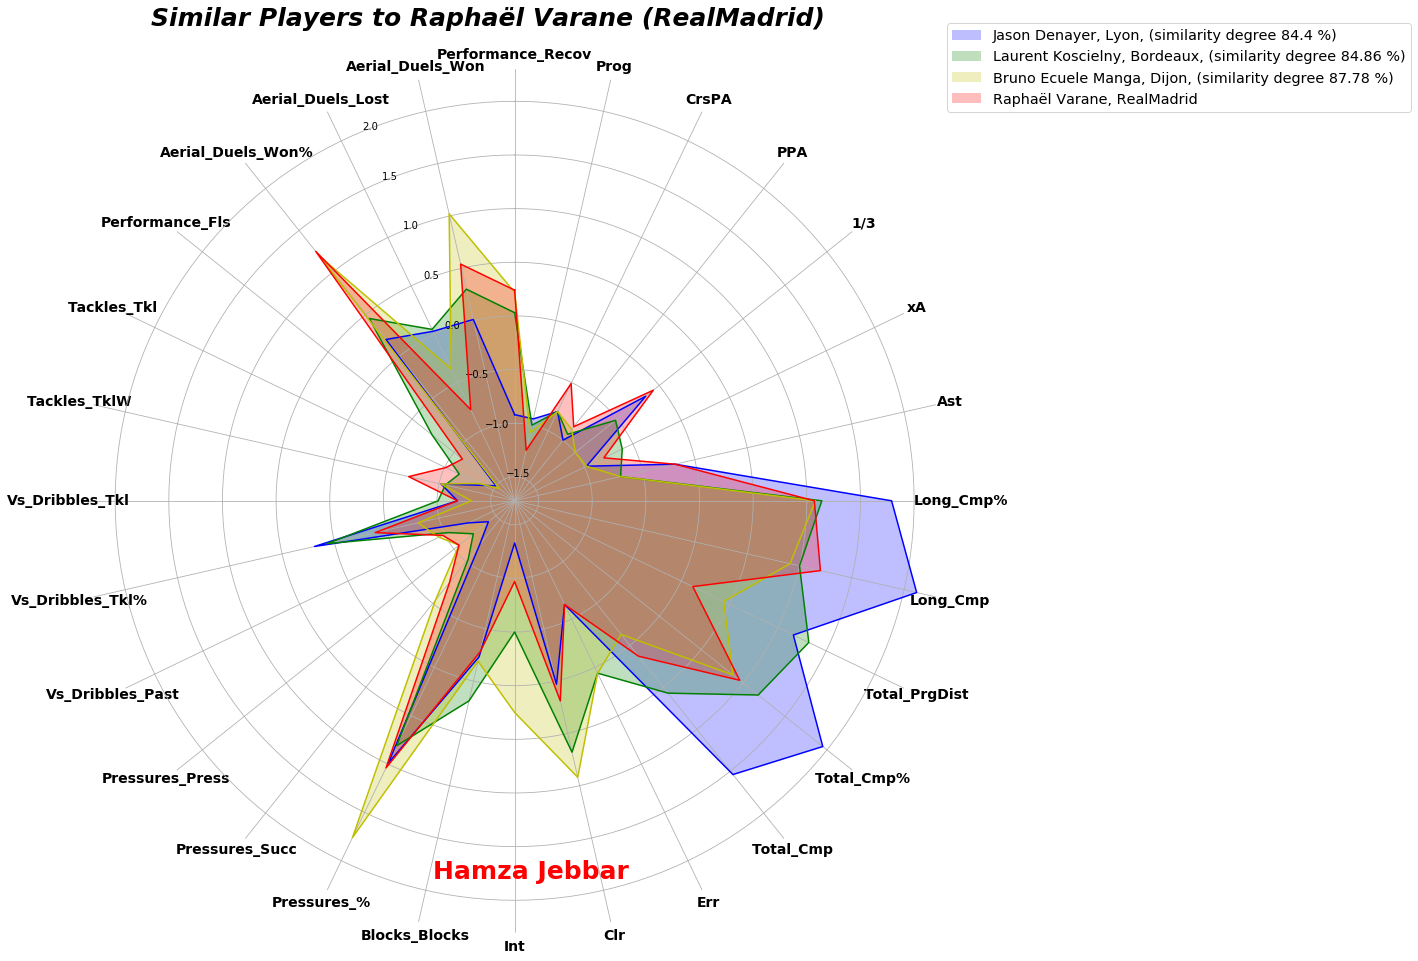

In [17]:
player_cos, x = get_similar_players("Varane")
player_cos.append('')
players_data = [x.iloc[:,5:].iloc[i,:].values for i in range(4)]
data = [list(x.iloc[:,5:]),players_data]
N = len(data[0])
theta = radar_factory(N, frame='polygon')
#data = example_data()
spoke_labels = data.pop(0)

    
fig, ax = plt.subplots(figsize=(30, 15), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
colors = ['b', 'g', 'y', 'r']
# Plot the four cases from the example data on separate axes
#for (title, case_data) in data:
    #ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     #horizontalalignment='center', verticalalignment='center')
case_data = data[0]
for d, color in zip(case_data, colors):
    ax.plot(theta, d, color=color, label='_nolegend_')
    ax.fill(theta, d, facecolor=color, alpha=0.25)
    subplot_kw=dict(size=14, weight='bold')
    ax.set_varlabels(spoke_labels, **subplot_kw )

# add legend relative to top-left plot
#ax = axes[0, 0]
labels = [list(x["Player"].values)[i] + ", " + list(x["Team"].values)[i] + ", (similarity degree " + str(round(player_cos[i]*100,2)) + " %)" for i in range (0,len(player_cos)-1)]
labels.append(list(x["Player"].values)[-1] + ", " + list(x["Team"].values)[-1])
labels = tuple(labels)
#ax = fig.add_axes([0.8, 0.1, 0.6, 0.75])
legend = ax.legend(labels, loc=(1., .95),
                       fontsize='x-large')
fig.text(0.5, 0.89, 'Similar Players to ' + list(x["Player"].values)[-1] + ' '  + '(' + list(x["Team"].values)[-1] + ')' ,
             horizontalalignment='center', color='black', weight='heavy', style =
         'italic',
            fontsize=25)
fig.text(0.52, 0.1, 'Hamza Jebbar' ,
             horizontalalignment='center', color='red', weight='bold',
            fontsize=25)
ax.spines['polar'].set_visible(False)
#ax.set_facecolor((0.39, 0.58, 0.84))
plt.savefig(fname = './radars/' + list(x["Player"].values)[-1], dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', papertype='a1', format=None)



plt.show()


In [ ]:
def get_columns_name():
    header = []
    columns_name = soup.find('thead')
    for row in columns_name.find_all('th'):
        name = row.get_text(strip=True, separator = "##")
        header.append(name)
    header = header[7:len(header)-1]
    return header
    

In [ ]:
def get_data():
    numbers = []
    data = soup.find('tbody')
    rows = data.find_all('tr')
    for row in rows:
        cell= row.find_all("th")
        numbers.append(cell[0].get_text(strip = True))
        cell= row.find_all("td")
        for i in range(len(cell)):
            if (cell[i].get_text(strip = True) == "Matches"): 
                pass
            else:
                numbers.append(cell[i].get_text(strip = True))
    return numbers


In [ ]:
def fill_blank(data_array):
    #result = filter(lambda x: x != "", data_array) 
    #result = map(lambda x: x if (x!="") else "Nan",data_array) 
    #return result
    for n, i in enumerate(data_array):
      if i == "":
        data_array[n] = "NaN"
    return data_array
z= fill_blank(get_data())
z

#get_data()[20] == "NaN"

In [ ]:
def fill_dataframe(data, columns):
    ar =[]
    data_length = len(data)
    columns_length = len(columns)
    rows = int(data_length/columns_length)
    for i in range(0,rows):
        j = i*columns_length
        k = (i+1)*columns_length
        ar.append(data[j:k])
    df = pd.DataFrame(ar, columns=columns)
    return df
fill_dataframe(fill_blank(get_data()),columns = get_columns_name())

